# Data mining project
- <font color=green>Database</font>: __[Link to database](http://www.chargecar.org/data/#)__
<br>
- <font color=green>Student</font>: **SimpleBro**
<br>
- <font color=green>JMBAG</font>: **#######785**
<br>
- <font color=green>Masters degree program</font>: **ITS**

<img src="https://i.ibb.co/hdH1mZh/born-to-feel.jpg" alt="Drawing" style="width: 250px;"/>

### ChargeCar dataset details
**Dataset characteristics:**
- <font color=green>Number of routs</font> : 49
    - **<font color=red>Across the U.S.</font>**
<br>
- <font color=green>Number of vehicles (electric)</font>: 2

|Index|Name|Mass|SI unit|
|:---|:---|:---|:---|
|1|Honda Civic 7th Generation|2700<br>1230|lb<br>kg|
|2|Scion xB|2615<br>1186|lb<br>kg|

- <font color=green>Number of attributes</font>: 11 [numeric]
<br>
- <font color=green>Target value (<font color=red>Dependant value</font>)</font>: Actual power
<br>
- <font color=green>Attribute information (in order)</font>:

|Index|Name|SI unit|Description|
|:---|:---|:---|:---|
|1|GMT time ||Greenwich mean time|
|2|Relative time|s|Time since the beggining of the rout<br>Data is logged every 2 s<br>Every root starts at 0 s|
|3|Elevation|m|Elevation point value at a given time|
|4|Planar distance|m|Distance passed since the last log|
|5|Adjusted distance|m|Adjusted "Planar distance"|
|6|Speed|m/s|Speed of a vehicle at time of log|
|7|Acceleration|m/s^2|Acceleration of a vehicle at time of log|
|8|Power based on model|kW|Derived power value at time of log based on a regression model which is not provided|
|9|<font color=red>Actual power</font>|<font color=red>kW</font>|<font color=red> Actual power value at time of log measured onboard</font>|
|10|Current|A|Current value at time of log|
|11|Voltage|V|Voltage value at time of log|

### Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
import math
import operator
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import display
from sklearn.utils import shuffle

### Example of a route in  San Jose

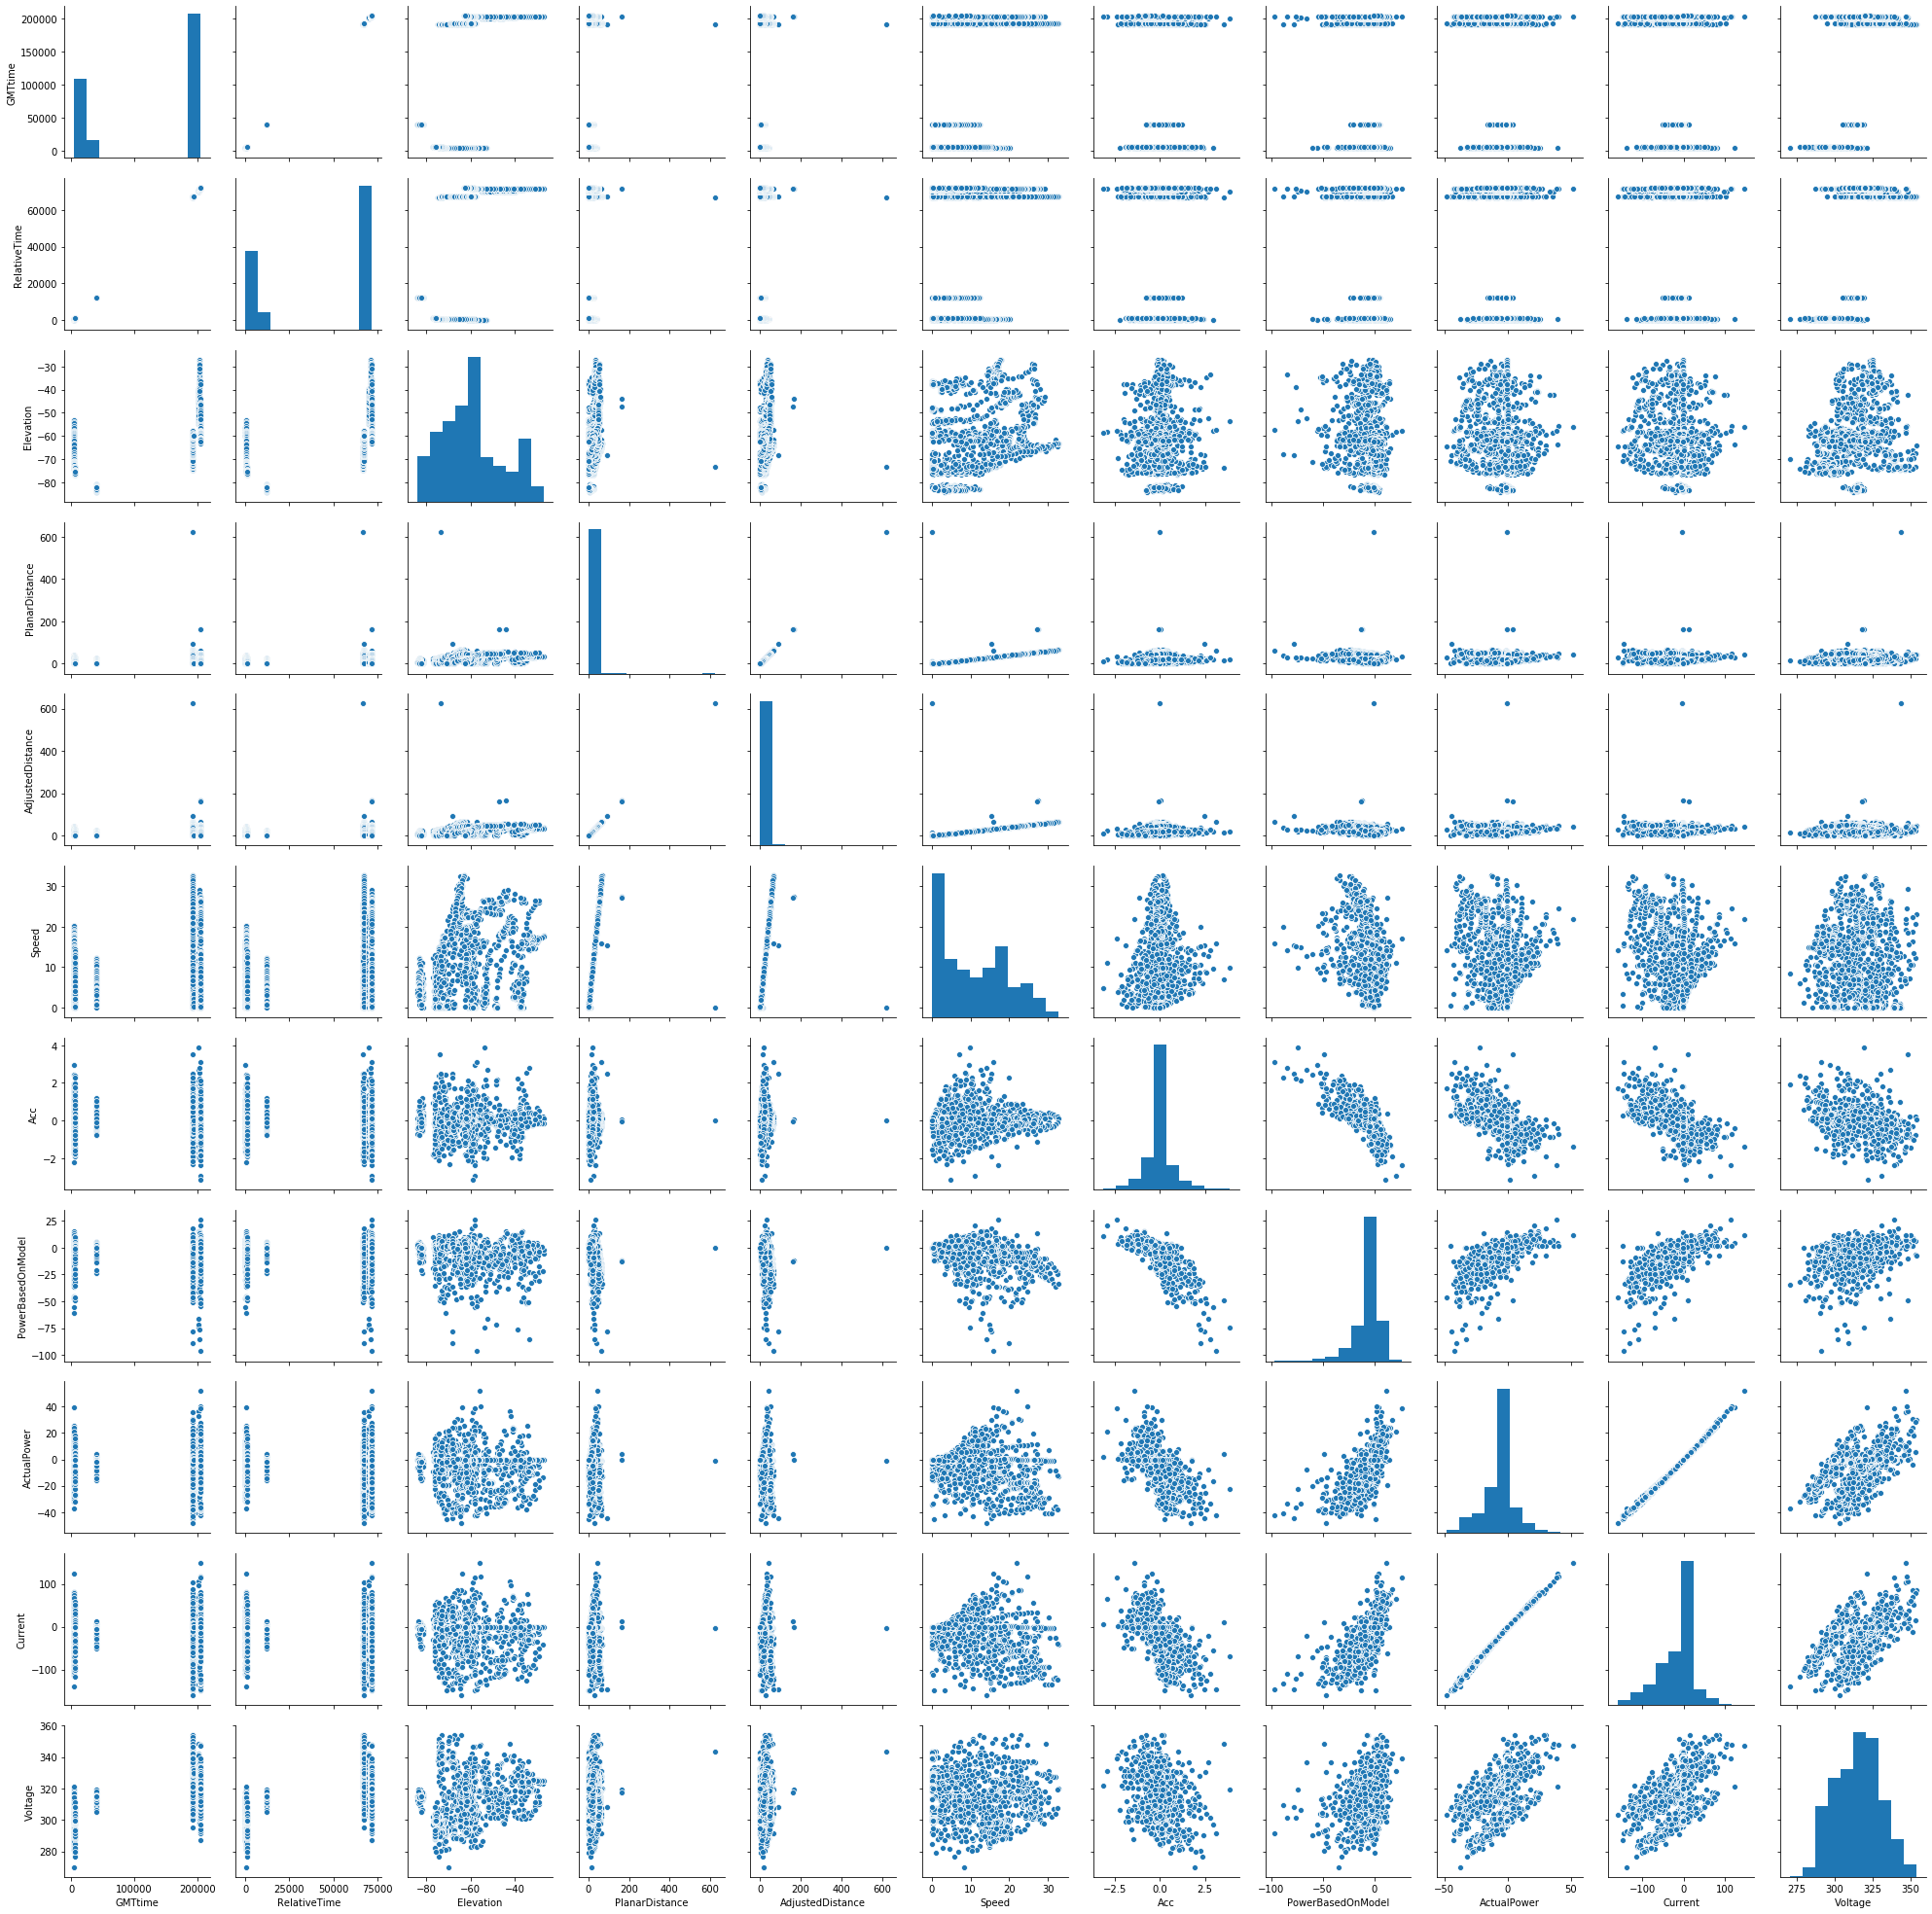

In [3]:
url = 'C:/Users/SimpleBro/Desktop/RP_Podaci/SimpleBro - energija/ChargeCarData/scan_tool_datas/CA/San Jose/473.txt'
col = ['GMTtime', 'RelativeTime', 'Elevation', 'PlanarDistance', 'AdjustedDistance', 'Speed',
                            'Acc', 'PowerBasedOnModel', 'ActualPower', 'Current', 'Voltage']
data = pd.read_csv(url, delim_whitespace=False, names=col)

sns.pairplot(data)


###  Project Workflow

#### Pre-process

|Step|Description|Approach|Output|
|:---|:---|:---|:---|
|1|Extract URL of every individual root|Manual|.txt file with 49 URL's|
|2|Loop through URL.txt file|Automated||
|2.1|Load root data|Automated|(m, 6) Array|
|2.2|Divide current root into n number of smaller roots<ul><li>New root has to contain atleast 200 data points</li></ul>|Automated|n number of new roots|
|2.3|Create new columns (Force, Power, Energy) for every new root<ul><li>Values of each row in new columns are derived from pre-existing column-row values</li></ul>|Automated|(m, 9) Array|
|2.4|For each column in each rute calculate:<ul><li>Average value</li><li>Average difference between two consecutive data points</li><li>Median value</li><li>Standard deviation</li></ul>Output of the whole route will be one row with 27 columns|Automated|**<font color=red>(1, 27)</font>** Array|
|2.5|Append processed route to main array|Automated|(m, 27) Array|
|3|Validate output (main) array by removing rows (roots) that might be outliers<br>Validation is based on the given function:<ul><li>lowerOk = Min. value of column + Standard dev. of column</li><li>upperOk = Max. value of column - Standard dev. of column</li><li>lowerOk <= row-column value <= upperOk</li></ul>Validation is performed in two steps:<ul><li>1) Drop rows that do not meet the requirements based on the column 'AverageAccelerationDifference'<ul><li>AvgAccDiff. because if the difference is too high that means that the power output will probably be chaotic</li></ul></li><li>2) Drop rows that do not meet the requirements based on the column 'AvgActualPower'<ul><li>Making sure the remove the remaining outliers</li></ul></li><ul>|Automated|(m, 27) Array|
|4|Extract main array to csv file|Automated|.txt file|
    
#### Regression model

|Step|Description|Approach|Output|
|:---|:---|:---|:---|
|1|Run regression models on processed data:<ul><li>Multiple Linear Regression Model</li><li>Data Tree Regression Model</li><li>Polynominal Multiple Linear Regression Model</li></ul>|Automated|Regression model accuracy|
|2|If the accuracy is low|Automated||
|2.1|Find the best fit combination of columns via Brute Force method|Automated|Combination of columns that generate the best model accuracy|
|2.2|Run regression models using best fit combination columns of proccesed data|Automated|Regression model accuracy|
|3|Visualize generated results|Automated|Visaul presentation of results|



### Pre-process

### Pre-process (necessary classes and functions)

In [ ]:
class Misc:
    class DataLoad:
        def csvReader(url):
            '''
            Return csv_Data as python matrix\n
            Generates array with column names listed as:\n
            ['GMTtime', 'RelativeTime', 'Elevation', 'PlanarDistance', 'AdjustedDistance', 'Speed', 'Acc', 'PowerBasedOnModel', 'ActualPower', 'Current', 'Voltage']

            :param url: Path to data folder
            :return: Matrix shape of loaded csv_Data
            '''
            colNames = ['GMTtime', 'RelativeTime', 'Elevation', 'PlanarDistance', 'AdjustedDistance', 'Speed',
                            'Acc', 'PowerBasedOnModel', 'ActualPower', 'Current', 'Voltage']
            mainData = pd.read_csv(url, delim_whitespace=False, names=colNames)
            return mainData

        def getData(parentMatrix, xtype):
            '''
            Return pre-defined combination of columns from input matrix

            :param parentMatrix: Parent (input) matrix
            :param xtype: Type of return combination of columns (data)
            :return: Matrix with specified columns from parentMatrix
            '''
            if xtype == 1:
                x = parentMatrix[['Elevation', 'Speed', 'Acc']].values  # .values.reshape(-1, 1)
                return x
            elif xtype == 2:
                y = parentMatrix[['Elevation', 'Speed', 'Acc', 'Current', 'Voltage']].values  # .values.reshape(-1, 1)
                return y
            elif xtype == 3:
                z = parentMatrix[['Elevation', 'Speed', 'Acc', 'ActualPower']].values  # .values.reshape(-1, 1)
                return z
            elif xtype == 'ecalc':
                h = parentMatrix[['RelativeTime', 'AdjustedDistance', 'Elevation', 'Speed', 'Acc', 'ActualPower']].values
                return h
    class BigMDivision:
        def birthOfNewM(bigM):  ## Each new matrix has to have alteast 200 rows!
            '''
            Creation of n new matrixes by dividing input matrix into smaller segments using function divideEtImpera

            :param bigM: Parent (input) matrix
            :return: New matrix that is a segment of bigM matrix
            '''
            bigMRowSize = np.size(bigM, 0)  ## The biggest file contains 5350 rows...
            if bigMRowSize < 200:
                return bigM  ## Too small sample to crease atleast two new lists
            else:
                n = math.floor(bigMRowSize / 200)  ## the number of new lists
                return Misc.BigMDivision.divideEtImpera(bigM, n)

        def divideEtImpera(bigM, numOfDivisions):  ##numOfDivisions is the number of new lists
            '''
            Creation of n new matrixes by dividing input matrix into smaller segments

            :param bigM: Parent (input) matrix
            :param numOfDivisions: Projected number of new matrixes that have to be derived from input matix
            :return: New matrix that is a segment of bigM matrix
            '''
            bigMRowSize = np.size(bigM, 0)
            bigMColSize = np.size(bigM, 1)
            smallMCollection = []
            for i in range(numOfDivisions):
                smallMRowSize = math.floor(bigMRowSize / numOfDivisions)  ## how many rows will be in the new matrix
                newM = np.random.rand(smallMRowSize, bigMColSize)
                if i == 0:
                    newM[0:smallMRowSize, 0] = bigM[0: smallMRowSize, 0]  ## 0 to 200 ## RelativeTime
                    newM[0:smallMRowSize, 1] = bigM[0: smallMRowSize, 1]  ## AdjustedDistance
                    newM[0:smallMRowSize, 2] = bigM[0: smallMRowSize, 2]  ## Elevation
                    newM[0:smallMRowSize, 3] = bigM[0: smallMRowSize, 3]  ## Speed
                    newM[0:smallMRowSize, 4] = bigM[0: smallMRowSize, 4]  ## Acc
                    newM[0:smallMRowSize, 5] = bigM[0: smallMRowSize, 5]  ## ActualPower
                    smallMCollection.append(newM)
                else:
                    lowerLimit = math.floor(smallMRowSize * i)
                    upperLimit = math.floor(smallMRowSize * (i + 1))
                    if i == numOfDivisions:
                        lowerLimit = math.floor(smallMRowSize * i)
                        upperLimit = math.floor(bigMRowSize - 1)
                    if upperLimit > bigMRowSize:
                        continue
                    newM[0:smallMRowSize, 0] = bigM[lowerLimit: upperLimit, 0]  ## (i = 1) 200 to 400 ## RelativeTime
                    newM[0:smallMRowSize, 1] = bigM[lowerLimit: upperLimit, 1]  ## AdjustedDistance
                    newM[0:smallMRowSize, 2] = bigM[lowerLimit: upperLimit, 2]  ## Elevation
                    newM[0:smallMRowSize, 3] = bigM[lowerLimit: upperLimit, 3]  ## Speed
                    newM[0:smallMRowSize, 4] = bigM[lowerLimit: upperLimit, 4]  ## Acc
                    newM[0:smallMRowSize, 5] = bigM[lowerLimit: upperLimit, 5]  ## ActualPower
                    smallMCollection.append(newM)
            return smallMCollection

        def singleMBirth(smallM):
            '''
            Return modified input matrix. Add new columns (Force, Power, Energy)\n
            Calculates new column-row values by taking in consideration column-row values from input matrix

            :param smallM: Parent (input) matrix
            :return: Modified input matrix
            '''
            # mCols = np.size(smallM, 1)
            # mRows = np.size(smallM, 0)
            mF = list()
            mP = list()
            mE = list()
            dramTeam = []
            for i in range(len(smallM)):
                if i == len(smallM) - 1: ## i + 1 does not exist
                    continue
                v1 = smallM[i, 3] ## speed
                t1 = smallM[i, 0] ## time
                d1 = smallM[i, 1] ## distance
                h1 = smallM[i, 2] ## elevation
                v2 = smallM[i + 1, 3]
                t2 = smallM[i + 1, 0]
                d2 = smallM[i + 1, 1]
                h2 = smallM[i + 1, 2]
                a = smallM[i, 4] ## given acceleration
                # a = Misc.MiscCalc.accCalc(v1, v2, t1, t2) ## acceleration
                i = Misc.MiscCalc.angleCalc(d1, d2, h1, h2) ## the angel in radians
                d = Misc.MiscCalc.diffCalc(d1, d2) ## delta distance
                F = Misc.MiscCalc.forceCalc(a, i, v1) ## required force
                P = Misc.MiscCalc.powerCalc(F, v1) ## power
                E = Misc.MiscCalc.eCalc(P, Misc.MiscCalc.diffCalc(d1, d2), v1, Misc.MiscCalc.diffCalc(t1, t2)) ## kW
                mF.append(F)
                mP.append(P)
                mE.append(E)
            dramTeam.append(np.transpose(mF))
            dramTeam.append(np.transpose(mP))
            dramTeam.append(np.transpose(mE))
            return dramTeam

    class PreProc:
        def xValidation(xM, var, mux=False): ##xM matrix
            '''
            Based on selected column (ancor column) of the input matrix, process the selected column-row values in hope of 
            exterminating outliers.\n
            Return rows of input matrix that correspond to rows that were approved by the process validation of ancor column

            :param xM: Parent (input) matrix
            :param var: Input variable defining the ancor column
            :param mux: Input variable defining the shape of input matrix
            :return: Purged input matrix
            '''
            # mCols = np.size(xM, 1)
            if 1 == 1:# mCols == 1: ## acceleration serves as the principal value
                if var == 'acc':
                    g = 4
                    e = 0.3
                elif var == 'apower':
                    g = 26
                    e = 1.5
                elif var == 'spd':
                    g = 6
                    e = 0.41
                elif var == 'force':
                    g = 6
                    e = 1.5
                elif var == 'power':
                    g = 7
                    e = 1.5
                elif var == 'energy':
                    g = 8
                    e = 1.5
                elif var == 'AvgAccelerationDiff':
                    g = 11
                    e = 0.3
                elif var == 'AvgSpeedDiff':
                    g = 7
                    e = 0.3
                n = np.array(xM)
                m = np.array(xM[:, g]) ## acc column = 4
                xMin = min(m)
                xMax = max(m)
                xMed = np.median(m)
                xStd = np.std(m) * e
                lowerOk = xMin + xStd
                upperOk = xMax - xStd
                purgedM = []
                k = 0
                for j in n:
                    if lowerOk <= j[g] <= upperOk:
                        purgedM.append(j)
            if mux == True:
                return  pd.DataFrame(purgedM, columns=['AvgDistanceDiff', 'DistTraveled', 'AvgElevation', 'AvgElevationDiff', 'MedElevation',
                'StdElevation', 'AvgSpeed', 'AvgSpeedDiff', 'MedSpeed', 'StdSpeed', 'AvgAcceleration', 'AvgAccelerationDiff', 'MedAcceleration',
                'StdAcceleration', 'AvgForce', 'AvgForceDiff', 'MedForce', 'StdForce', 'AvgPower', 'AvgPowerDiff', 'MedPower', 'StdPower', 'AvgE',
                'AvgEDiff', 'MedE', 'StdE', 'AvgActualPower'])
            # return pd.DataFrame(purgedM, columns=['RelativeTime', 'AdjustedDistance', 'Elevation', 'Speed', 'Acc', 'ActualPower', 'Force', 'Power',
            #                                       'Energy'])
            return  np.array(purgedM)

        def preProcMatrix(xMatrix, numOfCols):
            '''
            Use various statistical methods based on parent (input) matrix values\n
            Parent matrix represents all values generated within a certain vehicle rout\n
            Function aims to create one row for entire rout by using statistical methods\n
            \n
             e.g. OUTPUT: (Columns of new matrix)\n
            'AvgDistanceDiff': AvgDistanceDiff, 'DistTraveled': DistTraveled, 'AvgElevation': AvgElevation, 'AvgElevationDiff' : AvgElevationDiff, 'MedElevation': MedElevation, 'StdElevation': StdElevation, 'AvgSpeed': AvgSpeed, 'AvgSpeedDiff' : AvgSpeedDiff, 'MedSpeed': MedSpeed, 'StdSpeed': StdSpeed, 'AvgAcceleration': AvgAcceleration, 'AvgAccelerationDiff': AvgAccelerationDiff, 'MedAcceleration': MedAcceleration, 'StdAcceleration': StdAcceleration, 'AvgForce': AvgForce, 'AvgForceDiff': AvgForceDiff, 'MedForce': MedForce, 'StdForce': StdForce, 'AvgPower': AvgPower, 'AvgPowerDiff': AvgPowerDiff, 'MedPower': MedPower, 'StdPower': StdPower, 'AvgE': AvgE, 'AvgEDiff': AvgEDiff, 'MedE': MedE, 'StdE': StdE, 'AvgActualPower': ActualPower}

            :param xMatrix: Parent (input) matrix
            :param numOfCols: Number of columns in parent (input) matrix
            :return: New matrix derived from input matrix values
            '''
            kaizen = []
            # bigM = xMatrix.to_numpy()
            bigM = xMatrix
            for i in range(numOfCols):
                matrix = bigM[:, i]
                purgedM = matrix
                if i == 0: ## RelativeTime is irrelevant
                    continue
                elif i == 1: ## Distance is observed only in the original matrix
                    AvgDistanceDiff = Misc.MiscCalc.avgDiffCalc(matrix)
                    DistTraveled = Misc.MiscCalc.diffCalc(matrix[0], matrix[len(matrix) - 1])
                elif i == 2:
                    AvgElevation = Misc.MiscCalc.avgCalc(purgedM);
                    AvgElevationDiff = Misc.MiscCalc.avgDiffCalc(purgedM);
                    MedElevation = np.median(purgedM);
                    StdElevation = np.std(purgedM);
                elif i == 3:
                    AvgSpeed = Misc.MiscCalc.avgCalc(purgedM);
                    AvgSpeedDiff = Misc.MiscCalc.avgDiffCalc(purgedM)
                    MedSpeed = np.median(purgedM);
                    StdSpeed = np.std(purgedM);
                elif i == 4:
                    AvgAcceleration = Misc.MiscCalc.avgCalc(purgedM);
                    AvgAccelerationDiff = Misc.MiscCalc.avgDiffCalc(purgedM)
                    MedAcceleration = np.median(purgedM);
                    StdAcceleration = np.std(purgedM);
                elif i == 5: ## Original Energy kW
                    ActualPower = Misc.MiscCalc.avgCalc(purgedM);
                elif i == 6: ## the force needed to overcome the sum of all resistance forces
                    AvgForce = Misc.MiscCalc.avgCalc(purgedM)
                    AvgForceDiff = Misc.MiscCalc.avgDiffCalc(purgedM)
                    MedForce = np.median(purgedM)
                    StdForce = np.std(purgedM)
                elif i == 7: ## the power
                    AvgPower = Misc.MiscCalc.avgCalc(purgedM)
                    AvgPowerDiff = Misc.MiscCalc.avgDiffCalc(purgedM)
                    MedPower = np.median(purgedM)
                    StdPower = np.std(purgedM)
                elif i == 8: ## electric energy kW
                    AvgE = Misc.MiscCalc.avgCalc(purgedM)
                    AvgEDiff = Misc.MiscCalc.avgDiffCalc(purgedM)
                    MedE = np.median(purgedM)
                    StdE = np.std(purgedM)
            if AvgDistanceDiff < 0: AvgDistanceDiff = AvgDistanceDiff * (-1) ## the diff should be a positive number
            if DistTraveled < 0: DistTraveled = DistTraveled * (-1)
            if AvgElevationDiff < 0: AvgElevationDiff = AvgElevationDiff * (-1)
            if AvgSpeed < 0: AvgSpeed = AvgSpeed * (-1)
            if AvgSpeedDiff < 0: AvgSpeedDiff = AvgSpeedDiff * (-1)
            if AvgAccelerationDiff < 0: AvgAccelerationDiff = AvgAccelerationDiff * (-1)
            if AvgForceDiff < 0: AvgForceDiff = AvgForceDiff * (-1)
            if AvgPowerDiff < 0: AvgPowerDiff = AvgPowerDiff * (-1)
            if AvgEDiff < 0: AvgEDiff = AvgEDiff * (-1)
            kaizen.append({'AvgDistanceDiff': AvgDistanceDiff, 'DistTraveled': DistTraveled,
                           'AvgElevation': AvgElevation, 'AvgElevationDiff' : AvgElevationDiff,
                           'MedElevation': MedElevation, 'StdElevation': StdElevation, 'AvgSpeed': AvgSpeed,
                           'AvgSpeedDiff' : AvgSpeedDiff, 'MedSpeed': MedSpeed, 'StdSpeed': StdSpeed,
                           'AvgAcceleration': AvgAcceleration, 'AvgAccelerationDiff': AvgAccelerationDiff,
                           'MedAcceleration': MedAcceleration, 'StdAcceleration': StdAcceleration,
                           'AvgForce': AvgForce, 'AvgForceDiff': AvgForceDiff, 'MedForce': MedForce,
                           'StdForce': StdForce, 'AvgPower': AvgPower, 'AvgPowerDiff': AvgPowerDiff,
                           'MedPower': MedPower, 'StdPower': StdPower, 'AvgE': AvgE,
                           'AvgEDiff': AvgEDiff, 'MedE': MedE, 'StdE': StdE,
                           'AvgActualPower': ActualPower}) ## 27 rows!
            return pd.DataFrame(kaizen)
    class MiscCalc: ## EnergyPath ==> a -> i -> d -> F -> P -> E
        def eCalc(P, d, v, dT): ##P -- power, d -- travelled distance [m], v -- speed [m/s], delta t [s]
            '''
            Function for calculating energy value of vehicle at observed point in time

            :param P: Power of vehicle at observed point in time [W]
            :param d: Distance travelled since last observed point in time [m]
            :param v: Vehicle speed at observed point in time [m/s]
            :param dT: Time passed since last observed point in time [s]
            :return: Energy value derived from input parameters [kW]
            '''
            if v == 0:
                return 0
            Ej = P * (d / v) ## E [J] energy in joules
            EkW = Ej / (1000 * dT) ## E [kW] electric power in kilowatts || kolowatt = joule / (1000 * t[s])
            return EkW

        def forceCalc(vehAcceleration, roadGrade, vehSpeed): ## const. params == Nissan Leaf
            '''
            Function for calculating the sum of forces acting on a vehicle travelling at a certain speed

            :param vehAcceleration: Vehicle acceleration at observed point in time [m/s^2]
            :param roadGrade: Road grade angle [°]
            :param vehSpeed: Vehicle speed at observed point in time [m/s]
            :return: Sum of forces [N]
            '''
            m = 1210 ## vehicle mass [kg] --
            g = 9.81 ## gravitation force
            crf = 0.008 ## rolling friction coefficient
            ro = 1.25 ## air density
            A = 2.19 ## vehicle front surface area
            cw = 0.29 ## air drag coefficient
            a = vehAcceleration
            if roadGrade == 0:
                i = 0
            else:
                i = roadGrade / (180 / math.pi)  ## from ° to rad
            v = vehSpeed
            G = m * g ## big G
            ## Resistance force acting on the vehicle || Grade + Rolling + Air
            Fr = (G * math.sin(i)) + (G * math.cos(i) * crf) + (0.5 * (ro * A * cw * math.pow(v, 2)))
            F = m * a * Fr
            return F

        def powerCalc(force, v1): ## force -> F [N], v1 -> speed of the vehicle in the observed point [m/s]
            '''
            Function for calculating the power demand of a vehicle travelling at a certain speed

            :param force: Sum of forces acting on a vehicle travelling at a certain speed [F]
            :param v1: Vehicle speed at observed point in time [m/s]
            :return: Power demand of vehicle travelling at a certain speed [W]
            '''
            energyEfficiency = 0.9 ## eE is the energy efficiency (literature)
            v = v1 * 3.6 ## m/s -> km/h
            P = (force * v) / energyEfficiency
            return  P

        def accCalc(v1, v2, t1, t2): ## v1 -- first speed, v2 -- second speed, v [m/s], t[s]
            '''
            Function for calculating vehicle acceleration at observed point in time

            :param v1: Vehicle speed at observed point in time (i) [m/s]
            :param v2: Vehicle speed at observed point in time (i + 1) [m/s]
            :param t1: Logged time at observed point (i) [s]
            :param t2: Logged time at observed point (i + 1) [s]
            :return: Acceleration value of a vehicle at observed point in time [m/s^2]
            '''
            dV = v2 - v1
            dT = t2 - t1
            a = dV / dT
            return a

        def diffCalc(x1, x2):  ## x1 -- first read value, x2 second read value in the list
            '''
            Function for calculating the absolute difference value of two input variables

            :param x1: Observed value at point (i)
            :param x2: Observed value at point (i + 1)
            :return: Absolute difference value of two input variables
            '''
            return abs(x2 - x1)  ## 10 - 8 = 2 m

        def angleCalc(d1, d2, h1, h2):  ## h1 starting point, h2 end point (elevation)
            '''
            Function for calculating the observed road angle

            :param d1: Logged distance value at observed point in time and space (i) [m]
            :param d2: Logged distance value at observed point in time and space (i + 1) [m]
            :param h1: Logged elevation value at observed point in time and space (i) [m]
            :param h2: Logged elevation value at observed point in time and space (i + 1) [m]
            :return: Road angle [°]
            '''
            distance = Misc.MiscCalc.diffCalc(d1, d2)
            if distance == 0: ## did not move, angel = 0
                return 0
            if h1 > h2:  ## start higher than the end -> downhill, angel is negative
                h = h2 - h1
            elif h2 > h1:  ## end higher than the start -> uphill, angel is positive
                h = h2 - h1
            else:  ## both points on the same elevation
                h = 0
            roadAngle = math.atan(h / distance) * (180 / math.pi)
            return roadAngle  ## returns the angel in degrees

        def scale(x):
            '''
            Function for scaling input variables\n
            Scale value to be within [0, 1] scope

            :param x: Input variable
            :return: Scaled input variable
            '''
            y = (x - x.min()) / (x.max() - x.min())
            return y

        def avgCalc(xMatrix):
            '''
            Function for calculating the average value of input matrix

            :param xMatrix: Input matrix
            :return: Average value of input matrix
            '''
            if len(xMatrix) == 0:
                return 0
            else:
                return round((sum(xMatrix) / len(xMatrix)), 10)

        def avgDiffCalc(bigM): ## list(matrix[:, i])
            '''
            Function for calculating the average difference value occured in the input matrix between two points in time (i) and (i + 1)

            :param bigM: Input matrix
            :return: Average difference value between two points in time (i) and (i + 1)
            '''
            n = len(bigM)
            if n == 0:
                return np.nan
            count = 0
            diff = 0
            sumOfx = 0
            for i in bigM: ## for each row
                if count == n - 1:
                    break
                diff = bigM[count + 1] - i ## e.g. d2 - d1 = real travelled distance
                sumOfx += diff
                count += 1
            if sumOfx == 0 or count == 0: return 0
            return (sumOfx / count)

### Processing raw data and saving it to .txt file

In [ ]:
# appendUrl = 'C:/Users/SimpleBro/Desktop/KaizenPy.txt'
# appendFile = open(appendUrl, 'a')
carDataUrl = 'C:/Users/SimpleBro/Desktop/carDataRoots.txt'
carData = open(carDataUrl, 'r')
originRoot = "C:/Users/SimpleBro/Desktop/RP_Podaci/energija/ChargeCarData/scan_tool_datas/"
bigM = []
aaaaa = 0
for root in carData:
    url = originRoot + root
    url = url[:-1] ## At the end of the root it puts \n in the string, eliminate it
    data = Misc.DataLoad.csvReader(url)
    matrix = data.dropna()
    mainData = pd.DataFrame(Misc.DataLoad.getData(data, 'ecalc')) ## fetch only some rows
    mmPower = Misc.BigMDivision.birthOfNewM(mainData.values) ## divide the matrix on n matrix
    quizlyBear = list()
    for i in mmPower: ## for each new matrix
        aDream = Misc.BigMDivision.singleMBirth(i) ## create columns with data (Force, Power, Energy)
        i = i[:-1, :]
        zen = i
        for l in aDream: ## add each new column to the main matrix
            l = np.reshape(l, (np.size(l, 0),1))
            zen = np.hstack((zen, l)) ## stack them horizontali (per columns) /vstack is per rows
        kaizen = zen
        d = len(kaizen)
        if d == 0:
            continue
        numOfCols = np.size(kaizen, 1)
        aa = Misc.PreProc.preProcMatrix(kaizen, numOfCols) ## return one row per matrix
        qq = []
        for j in aa:
            qq.append(aa[j].values.tolist())
        quizlyBear.append(qq)
    for i in quizlyBear: ## wirte the results to the destination
        bigM.append({'AvgDistanceDiff': i[0][0], 'DistTraveled': i[1][0],
                       'AvgElevation': i[2][0], 'AvgElevationDiff': i[3][0],
                       'MedElevation': i[4][0], 'StdElevation': i[5][0], 'AvgSpeed': i[6][0],
                       'AvgSpeedDiff': i[7][0], 'MedSpeed': i[8][0], 'StdSpeed': i[9][0],
                       'AvgAcceleration': i[10][0], 'AvgAccelerationDiff': i[11][0],
                       'MedAcceleration': i[12][0], 'StdAcceleration': i[13][0],
                       'AvgForce': i[14][0], 'AvgForceDiff': i[15][0], 'MedForce': i[16][0],
                       'StdForce': i[17][0], 'AvgPower': i[18][0], 'AvgPowerDiff': i[19][0],
                       'MedPower': i[20][0], 'StdPower': i[21][0], 'AvgE': i[22][0],
                       'AvgEDiff': i[23][0], 'MedE': i[24][0], 'StdE': i[25][0],
                       'AvgActualPower': i[26][0]})  ## 27 stupaca!!!
bigM = pd.DataFrame(bigM)
bigM = Misc.PreProc.xValidation(bigM.values, 'AvgAccelerationDiff', True) ##AvgAccelerationDiff
bigM = Misc.PreProc.xValidation(bigM.values, 'apower', True)
bigM.to_csv('C:/Users/SimpleBro/Desktop/KaizenPythonV2.txt', header=False, index=False)

### Fetching data and preparing it for prediction

In [19]:
url = 'C:/Users/SimpleBro/Desktop/Tarantino/Kaizen_Sum_Classic_Tarantino.txt'
colNames = ['AvgDistanceDiff', 'DistTraveled', 'AvgElevation', 'AvgElevationDiff', 'MedElevation',
                'StdElevation', 'AvgSpeed', 'AvgSpeedDiff', 'MedSpeed', 'StdSpeed', 'AvgAcceleration', 'AvgAccelerationDiff', 'MedAcceleration',
                'StdAcceleration', 'SumPower', 'SumEnergy', 'AvgActualPower']
mainData = pd.read_csv(url, delim_whitespace=False, names=colNames)
mainData = mainData.dropna()
print(mainData.describe())
display(mainData.describe())

       AvgDistanceDiff  DistTraveled  AvgElevation  AvgElevationDiff  \
count       350.000000    350.000000    350.000000        350.000000   
mean          0.081059     17.157352    102.114793          0.113062   
std           0.069541     14.727910    144.034603          0.142733   
min           0.000162      0.033066    -87.885494          0.000000   
25%           0.020501      4.401158      3.933175          0.029882   
50%           0.071034     15.115741     48.496990          0.072571   
75%           0.118175     25.328848    188.745380          0.148645   
max           0.274550     57.560586    505.059377          1.349829   

       MedElevation  StdElevation    AvgSpeed  AvgSpeedDiff    MedSpeed  \
count    350.000000    350.000000  350.000000    350.000000  350.000000   
mean     101.654283     10.756085   11.104505      0.040344   11.354471   
std      144.801482      9.998305    6.939295      0.034658    7.966367   
min      -89.306400      0.459982    0.133846      

,AvgDistanceDiff,DistTraveled,AvgElevation,AvgElevationDiff,MedElevation,StdElevation,AvgSpeed,AvgSpeedDiff,MedSpeed,StdSpeed,AvgAcceleration,AvgAccelerationDiff,MedAcceleration,StdAcceleration,SumPower,SumEnergy,AvgActualPower
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,3.500000e+02,350.000000,350.000000,3.500000e+02,3.500000e+02,350.000000
mean,0.081059,17.157352,102.114793,0.113062,101.654283,10.756085,11.104505,0.040344,11.354471,5.268309,-0.000609,2.373173e-03,-0.001993,0.524287,-3.425522e+08,8.163850e+04,-6.714270
std,0.069541,14.727910,144.034603,0.142733,144.801482,9.998305,6.939295,0.034658,7.966367,2.545872,0.027285,2.626482e-03,0.021807,0.215324,3.271447e+09,3.704500e+05,4.648606
min,0.000162,0.033066,-87.885494,0.000000,-89.306400,0.459982,0.133846,0.000000,0.000000,0.111969,-0.082668,1.018553e-18,-0.095653,0.059181,-1.151574e+10,-2.633089e+06,-18.755646
25%,0.020501,4.401158,3.933175,0.029882,1.905000,4.435012,5.877782,0.010250,5.214721,3.950390,-0.017196,5.316408e-04,-0.010976,0.403525,-1.760691e+09,-9.283563e+04,-8.981897
50%,0.071034,15.115741,48.496990,0.072571,47.396400,7.816376,9.175700,0.035324,9.793849,5.210285,0.000165,1.378672e-03,0.000000,0.568166,-2.455451e+08,1.952377e+04,-5.292164
75%,0.118175,25.328848,188.745380,0.148645,189.280800,12.816015,15.143547,0.059087,16.724721,6.857694,0.017178,3.124269e-03,0.007319,0.661844,1.278960e+09,1.808169e+05,-3.404103
max,0.274550,57.560586,505.059377,1.349829,516.026399,83.919318,29.174457,0.137275,32.729004,12.670012,0.068528,1.446337e-02,0.063996,1.143556,1.285258e+10,1.898342e+06,-0.178911


### Finding the best combination of atributes via Brute force method

### Et tu, Brute Force?

In [20]:
scoreID = 0
scoreMax = -1000
bestDegScore = 0
ancor = 0
subset = []

dtype = str(input("'MLR' for baisc MLR, 'DT' for decision tree, 'Poly' for polynominal MLR!>> "))

def Predictor(subset, deg, dtyp):
    '''
    Function for predicting using Polynominal MLR/Decision Tree/MLR

    :param subset: List of column names (data atributes)
    :param degree: Degree of y=ax + b
    :return: Accuracy of used regression model
    '''
    x = mainData[subset].values
    y = mainData.AvgActualPower.values.reshape(-1, 1)
    if dtyp == 'MLR':
        regressor = LinearRegression()
    elif dtyp == 'DT':
        regressor = DecisionTreeRegressor(random_state=0)
    elif dtyp == 'Poly':
        poly = PolynomialFeatures(degree=deg)
        x = poly.fit_transform(x)
        regressor = LinearRegression()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = regressor.score(x_test, y_test)
    return score

for xyz_range in range(20):
    for i in range(len(colNames) - 1): ## all but the dependant variable
        names = colNames[:-1] ## re-init the cols
        ancor = colNames[i:i+1][0] ## present in each combination
        names.remove(ancor) ## Remove the ancor so that it does not match itself
        names = shuffle(names) ## Random permutation!
        names.insert(0, ancor)
        if dtype != 'Poly':
            for j in range(len(names)):
                subset = names[0:j + 1]
                score = Predictor(subset, 0, dtype)
                if score > scoreMax:
                    scoreMax = score
                    scoreID = subset
        elif dtype == 'Poly':
            for degree in [1, 2, 3, 4]:
                for j in range(len(names)):
                    subset = names[0:j + 1]
                    score = Predictor(subset, degree, dtype)
                    if score > scoreMax:
                        scoreMax = score
                        scoreID = subset
                        bestDegScore = degree

print('Max score ID:', scoreID)
print('Score value:', scoreMax)
print('Degree:', bestDegScore)

'MLR' for baisc MLR, 'DT' for decision tree, 'Poly' for polynominal MLR!>> Poly
Max score ID: ['MedSpeed', 'AvgAccelerationDiff', 'AvgAcceleration', 'StdAcceleration', 'AvgSpeedDiff', 'AvgDistanceDiff']
Score value: 0.9071588291056412
Degree: 2


### Results of pre-run brute force algorithm

In [18]:
vrsta = str(input("'MLR' for basic MLR, 'DT' for decision tree, 'Poly' for polynominal MLR!>> "))

if vrsta == 'MLR':
    scoreID = ['StdAcceleration', 'MedE', 'AvgPowerDiff', 'MedElevation', 'AvgForce', 'MedForce', 'StdSpeed', 'AvgForceDiff', 'AvgSpeed', 'StdPower', 'AvgElevation', 'AvgAcceleration']
    ## 0.863861
elif vrsta == 'DT':
    scoreID =  ['AvgElevation', 'AvgElevationDiff', 'AvgSpeed', 'AvgE', 'AvgEDiff', 'StdForce', 'AvgSpeedDiff', 'AvgPowerDiff', 'AvgForce', 'StdPower', 'StdE', 'MedPower', 'MedForce', 'StdElevation', 'AvgDistanceDiff', 'DistTraveled', 'AvgForceDiff']
    ## 0.875626
elif vrsta == 'Poly':
    scoreID = ['AvgAcceleration', 'AvgForceDiff', 'AvgEDiff', 'AvgForce', 'StdElevation', 'MedSpeed', 'AvgElevation', 'AvgPowerDiff', 'AvgSpeed', 'MedElevation', 'StdForce']
    ## 0.8638607277086746
    bestDegScore = 2
elif vrsta == 'QDT':
    scoreID = ['StdForce', 'MedElevation', 'MedForce', 'AvgDistanceDiff', 'AvgForce', 'AvgSpeedDiff', 'AvgElevationDiff', 'MedSpeed', 'AvgForceDiff', 'AvgSpeed', 'AvgPower']
    ## 0.9231880576268781
elif vrsta == 'QMLR':
    scoreID
elif vrsta == 'QPoly':
    scoreID
else:
    print('Fail.')
#['MedElevation', 'MedAcceleration', 'StdElevation', 'AvgSpeed']

'MLR' for baisc MLR, 'DT' for decision tree, 'Poly' for polynominal MLR!>> MLR


### Loading best fit data and splitting it for train/test session

In [19]:
kiss = scoreID

x = mainData[kiss].values ## Independant var
y = mainData.AvgActualPower.values.reshape(-1, 1) ## Dependant var
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Regression model based on input "vrsta"

In [20]:
if vrsta == 'MLR': ## Multiple Linear Regression 'MLR'
    regressor = LinearRegression()
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
elif vrsta == 'DT' or vrsta == 'QDT': ## Decision Tree Regression 'DT'
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    y_pred = np.c_[y_pred] ## Convert to array
elif vrsta == 'Poly': ## Polynominal MLR
    deg = bestDegScore
    poly = PolynomialFeatures(degree=deg)
    x_poly = poly.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.2, random_state=0)
    regressor = LinearRegression()
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
else:
    print('Wrong input!')

#                                 y = bx + a
# The "y" is the value we are trying to forecast, the "b" is the slope of the regression line, the "x" is
# the value of our independent value, and the "a" represents the y-intercept. The regression equation simply
# describes the relationship between the dependent variable (y) and the independent variable (x).

### Actual vs Predicted values

In [21]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
display(df)

,Actual,Predicted
0,-0.277117,-0.324972
1,-3.877065,-3.297535
2,-16.361533,-12.536986
3,-3.947983,-4.603122
4,-4.895997,-4.495939
...,...,...
65,-0.931971,-0.474766
66,-2.302778,-3.933263
67,-0.957964,-0.710929
68,-15.419443,-14.812538


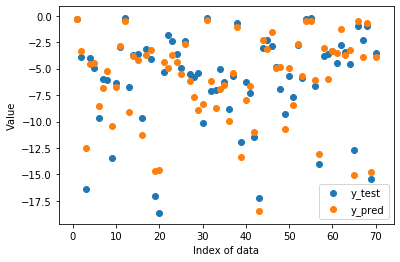

In [22]:
yrange = [i for i in range(1, len(y_test) + 1)]
plt.figure()
plt.scatter(y=y_test, x=yrange, label='y_test')
plt.xlabel('Index of data')
plt.ylabel('Value')
plt.scatter(y=y_pred, x=yrange, label='y_pred')
plt.legend()
plt.show()

### Statistical results of chosen model

In [23]:
avgmean = np.mean(mainData['AvgActualPower'].values)

if vrsta == 'MLR': ## Multiple Linear Regression 'MLR'
    results = pd.DataFrame({'Abbreviation': ['y', 'MAE', 'MSE', 'RMSE', 'MF'], 'Description': ['Dependant avg. mean val.',
                        'Mean-absolute error', 'Mean-squared error', 'Root-mean-squared error', 'Model fit'], 'Result': 
                        [avgmean, metrics.mean_absolute_error(y_test, y_pred), metrics.mean_squared_error(y_test, y_pred), 
                        np.sqrt(metrics.mean_squared_error(y_test, y_pred)), metrics.r2_score(y_test, y_pred)], 
                        'Optimal': ['', 0, 0, 0, 1]})
elif vrsta == 'DT' or vrsta == 'QDT': ## Decision Tree Regression 'DT'
    results = pd.DataFrame({'Abbreviation': ['y', 'MAE', 'MSE', 'RMSE', 'MF', '', ''], 'Description': ['Dependant avg. mean val.',
                        'Mean-absolute error', 'Mean-squared error', 'Root-mean-squared error', 'Model fit', 'Dept of tree', 
                        'Nr. of leaveas'], 'Result': [avgmean, metrics.mean_absolute_error(y_test, y_pred), 
                        metrics.mean_squared_error(y_test, y_pred), np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 
                        metrics.r2_score(y_test, y_pred), regressor.get_depth(), regressor.get_n_leaves()], 'Optimal': 
                        ['', 0, 0, 0, 1, '', '']})
elif vrsta == 'Poly': ## Polynominal MLR
    results = pd.DataFrame({'Abbreviation': ['y', 'MAE', 'MSE', 'RMSE', 'MF', ''], 'Description': ['Dependant avg. mean val.', 
                        'Mean-absolute error', 'Mean-squared error', 'Root-mean-squared error', 'Model fit', 'Polynom degree'],
                        'Result': [avgmean, metrics.mean_absolute_error(y_test, y_pred), 
                        metrics.mean_squared_error(y_test, y_pred), np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 
                        metrics.r2_score(y_test, y_pred), bestDegScore], 'Optimal': ['', 0, 0, 0, 1, '']})

print('Model:', vrsta)
display(results)

Model: MLR


,Abbreviation,Description,Result,Optimal
0,y,Dependant avg. mean val.,-6.714270,
1,MAE,Mean-absolute error,1.069221,0
2,MSE,Mean-squared error,2.000484,0
3,RMSE,Root-mean-squared error,1.414385,0
4,MF,Model fit,0.896108,1


### Visualization of results

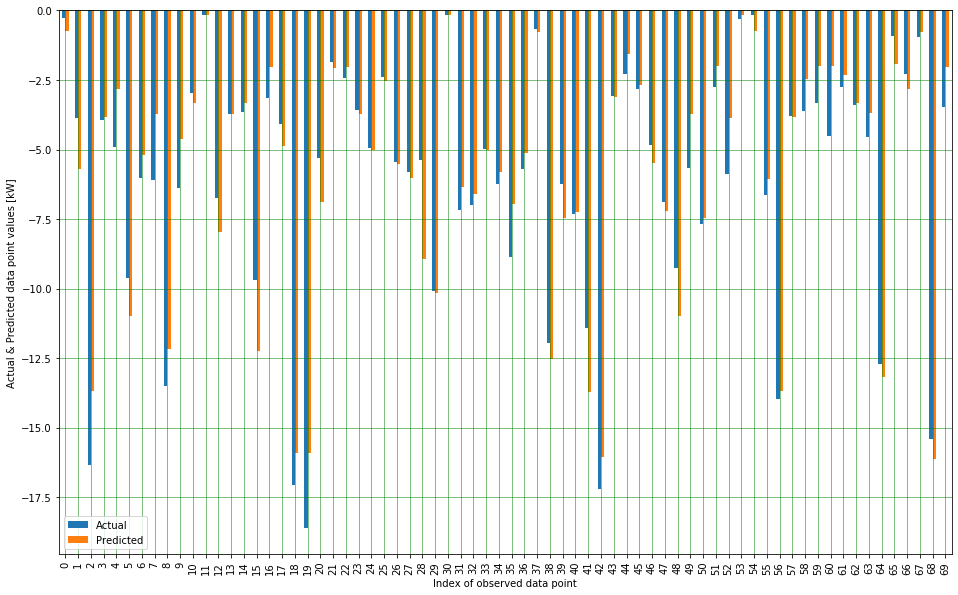

In [15]:
df1 = df.head(100)
df1.plot(kind='bar', figsize=(16, 10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.ylabel('Actual & Predicted data point values [kW]')
plt.xlabel('Index of observed data point')
plt.show()

Text(0.5, 1.0, 'Error of y_values')

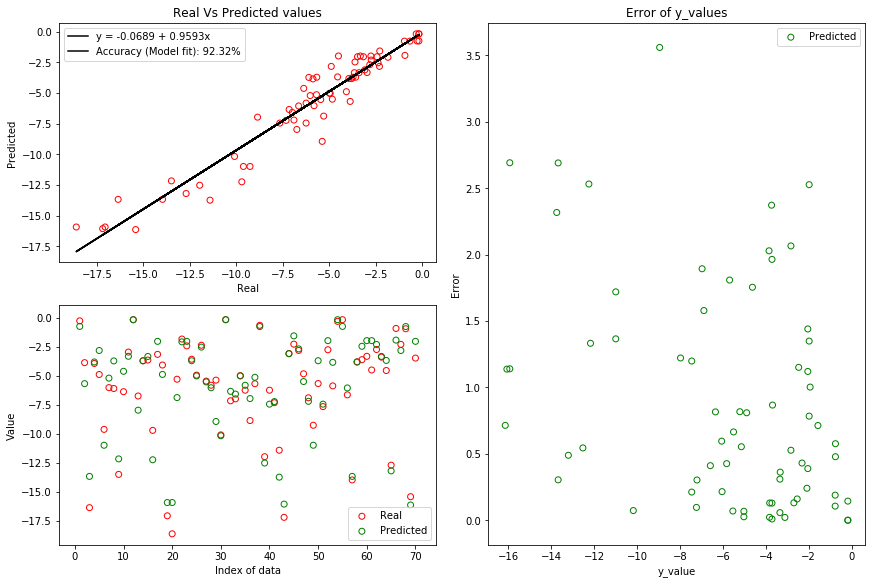

In [16]:
##---Omjer -> ABS diff between the predicted and real dependant value---##
omjer = abs(y_test - y_pred)
omjer = pd.DataFrame(omjer)

## best_fit(X, Y) calibrate the optimal line in consideration to the entry data
def best_fit(X, Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)
    numer = sum([xi*yi for xi, yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2
    b = numer / denum
    a = ybar - b * xbar
    # print('best fit line:\ny = {} + {}x'.format(str(a), str(b)))
    return a, b

a1, b1 = best_fit(y_test, y_pred)
y_fit1 = [a1 + b1 * xi for xi in y_test]

## GridSpec --> manipulate graphs
fig1 = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig1.add_gridspec(2, 2)

f1_ax1 = fig1.add_subplot(gs[0, 0])
f1_ax1.set_title('Real Vs Predicted values')
f1_ax1.set_xlabel('Real')
f1_ax1.set_ylabel('Predicted')
f1_ax1.scatter(y_test, y_pred, edgecolors='r', facecolors='none')
if b1[0] < 0:
    lab1 = 'y = {} {}x'.format(str(round(a1[0], 4)), str(round(b1[0], 4)))
else:
    lab1 = 'y = {} + {}x'.format(str(round(a1[0], 4)), str(round(b1[0], 4)))
f1_ax1.plot(y_test, y_fit1, label=lab1, color='k')
labAccuracy = 'Accuracy (Model fit): {}%'.format(round(metrics.r2_score(y_test, y_pred) * 100, 2))
f1_ax1.set_label = labAccuracy
label=[lab1, labAccuracy]
for i in range(1, len(label)):
    f1_ax1.plot(y_test, y_fit1, label=label[i], color='k')
f1_ax1.legend()

f1_ax2 = fig1.add_subplot(gs[1, 0])
a1, b1 = best_fit(y_test, y_pred)
y_fit1 = [a1 + b1 * xi for xi in y_test]

yrange = [i for i in range(1, len(y_test) + 1)]
f1_ax2.scatter(y=y_test, x=yrange, label='Real', edgecolors='r', facecolors='none')
f1_ax2.set_xlabel('Index of data')
f1_ax2.set_ylabel('Value')
f1_ax2.scatter(y=y_pred, x=yrange, label='Predicted', edgecolors='g', facecolors='none')
f1_ax2.legend()

f1_ax3 = fig1.add_subplot(gs[:, 1])
f1_ax3.scatter(y_pred, omjer, label='Predicted', edgecolors='g', facecolors='none')
# f1_ax3.scatter(y_test, omjer, label='Real', edgecolors='g', facecolors='none')
f1_ax3.legend()
f1_ax3.set_xlabel('y_value')
f1_ax3.set_ylabel('Error')
f1_ax3.set_title('Error of y_values')

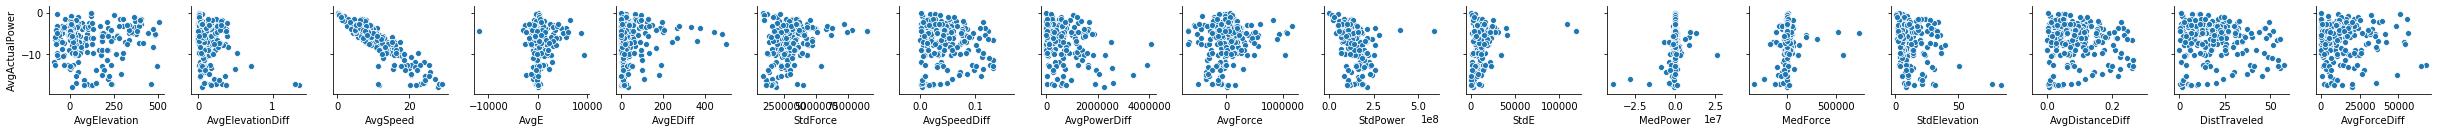

In [11]:
sns.pairplot(data=mainData, height=2, y_vars=['AvgActualPower'], x_vars=[x for x in kiss])

### Decision Tree u ovisnosti o varijabli "AvgSpeed"

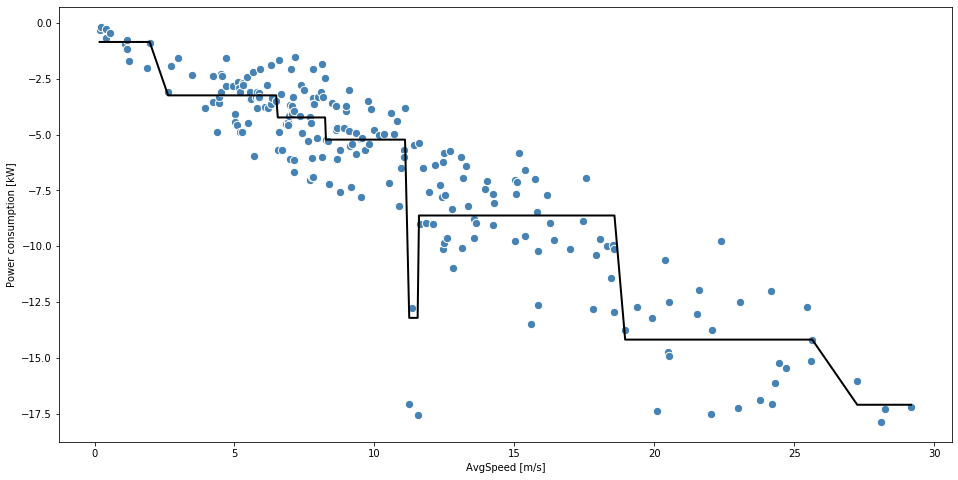

In [3]:
#-----------------------------------------Decision Tree with one var-----------------------------
from sklearn.tree import DecisionTreeRegressor   

x = mainData['AvgSpeed'].values.reshape(-1, 1) ## Independant var
y = mainData.AvgActualPower.values.reshape(-1, 1) ## Dependant var                           

sort_idx = x.flatten().argsort()                  
x = x[sort_idx]
y = y[sort_idx]

tree = DecisionTreeRegressor(random_state=0, criterion='mse', max_depth=3)       
tree.fit(x, y)

plt.figure(figsize=(16, 8))
plt.scatter(x, y, c='steelblue', edgecolor='white', s=70)
plt.plot(x, tree.predict(x), color='black', lw=2)
plt.xlabel('AvgSpeed [m/s]')
plt.ylabel('Power consumption [kW]')
plt.show()